### install basemap

#### Include "user: root" in the docker-compose file for jupyter-notebook (for sudo) 

#### In the jupyter-notebook container run the following command to install the dependencies:

sudo apt-get update -y

sudo apt-get install -y libgeos-dev

cd /usr/lib

sudo ln -s libgeos-3.3.3.so libgeos.so

sudo ln -s libgeos-3.3.3.so libgeos.so.1

wget https://github.com/matplotlib/basemap/archive/master.zip

pip install master.zip

In [1]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import random

## Preprocessing ##

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('cluster').getOrCreate()
df = spark.read.csv('hdfs://namenode/globalterrorismdb_0718dist.csv', inferSchema=True, header=True)
# text = sc.textFile('clean_data.csv')
df = df.select("latitude", "longitude")
df = df.na.drop()
df.show(3)

+---------+----------+
| latitude| longitude|
+---------+----------+
|18.456792|-69.951164|
|19.371887|-99.086624|
|15.478598|120.599741|
+---------+----------+
only showing top 3 rows



In [17]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = df.columns, outputCol = 'features')
final_df = assembler.transform(df)
final_df.show(3)
kmeans = KMeans(featuresCol = 'features', k=5)
model = kmeans.fit(final_df)

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|18.456792|-69.951164|[18.456792,-69.95...|
|19.371887|-99.086624|[19.371887,-99.08...|
|15.478598|120.599741|[15.478598,120.59...|
+---------+----------+--------------------+
only showing top 3 rows



In [18]:
# model.clusterCenters()
result = model.transform(final_df).select('latitude', 'longitude', 'prediction')

In [19]:
centroids = model.clusterCenters()

In [20]:
centroids

[array([ 0.64371946, 28.70692787]),
 array([  3.41095569, -79.75371451]),
 array([ 14.95648219, 100.29372134]),
 array([33.20457064, 52.77084867]),
 array([43.22073944,  6.15429182])]

### Post-processing ###

In [21]:
l = []
for centroid in centroids:
    l.append((centroid[0],centroid[1]))
print(l)
k = 5
clusters = dict()
for i in range(k):
    clusters[i] = []
    
colors = ['b', 'k', 'r', 'm', 'y', 'c', 'c']
for row in result.rdd.collect():
    lat, lng, index = row
    clusters[int(index)].append((lat, lng))

centroid_colors = zip(l, colors)

[(0.6437194614851686, 28.706927867074818), (3.4109556894758373, -79.75371450742604), (14.956482189489202, 100.29372133624068), (33.20457064158199, 52.770848672209425), (43.22073944253922, 6.154291817936627)]


## Plotting ##

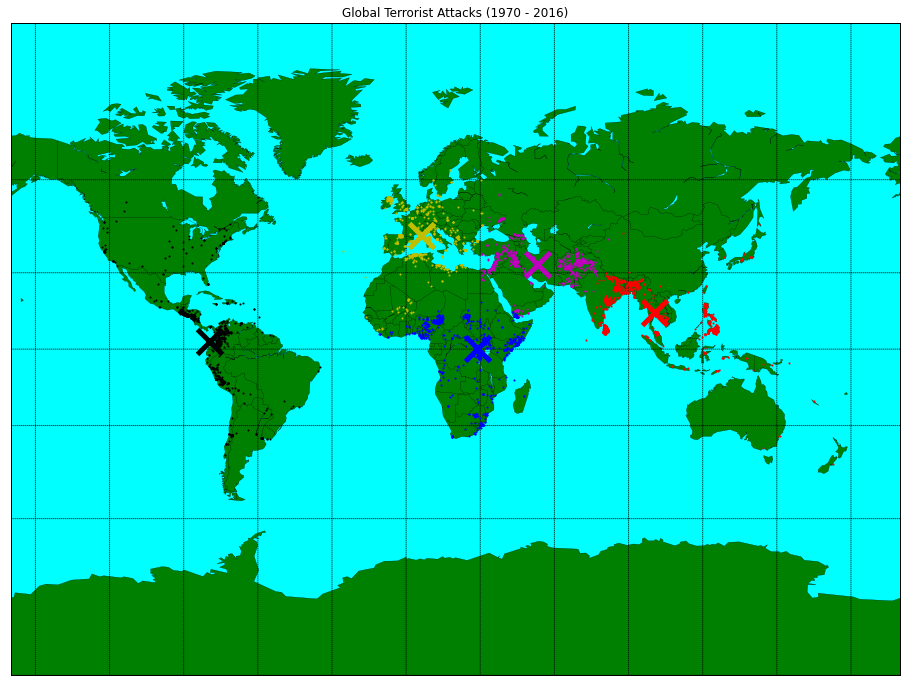

In [22]:

plt.figure(figsize=(24,12))
map = Basemap(projection='mill',lon_0=20,resolution='c')
# map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
 
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')

map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# plot clusters
for centroid_idx in range(k):
    cluster = clusters[centroid_idx]
    num_samples = 1000
    if (len(cluster) > 1000):
        random_samples = random.sample(cluster, num_samples)
    else:
        random_samples = cluster
    for (lat, lon) in random_samples:
        x, y = map(lon, lat)
        color = colors[centroid_idx]
        marker_style = color + 'o'
        map.plot(x, y, marker_style, markersize=1.05)

# plot centroids
for (lat, lon), color in centroid_colors:
    x,y = map(lon, lat)
    marker_style = color + 'x'
    map.plot(x, y, marker_style, markersize=25, mew=5)

title_string = "Global Terrorist Attacks (1970 - 2016)"
plt.title(title_string)

plt.show()